In [1]:
import pathos.multiprocessing as multiprocessing
import dill as pickle
%matplotlib inline
import matplotlib.pyplot as plt

from py_analyze_tools.sklearn import BasisFunctionConfiguration, ReaDDyElasticNetEstimator

from scipy.integrate import odeint
import py_analyze_tools.tools as pat
import numpy as np
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# simple sklearn estimator integration 

In [22]:
traj = pat.Trajectory("../generate/simple_trajectory_.h5")
traj.counts = traj.counts[:45*500]
traj.update()

max counts = 6000.0, min nonzero counts = 1.0


In [23]:
bfc = BasisFunctionConfiguration(traj)
bfc.add_fusion(0, 1, 2)
bfc.add_fission(2, 0, 1)
bfc.add_conversion(0, 1)
bfc.add_conversion(0, 3)
bfc.add_conversion(3, 0)

In [24]:
estimator = ReaDDyElasticNetEstimator(traj.counts, traj.dcounts_dt, bfc, 1. / (2. * traj.n_species * traj.n_time_steps), alpha=200, l1_ratio=0.5)

In [25]:
dcounts_dt = np.gradient(traj.counts, axis=0) / traj.time_step
estimator.fit(None, None)

ReaDDyElasticNetEstimator(alpha=200,
             basis_function_configuration=<py_analyze_tools.sklearn.BasisFunctionConfiguration object at 0x7f224ca12240>,
             counts=array([[  6.00000e+03,   6.00000e+03,   0.00000e+00,   0.00000e+00],
       [  5.99600e+03,   5.99700e+03,   3.00000e+00,   1.00000e+00],
       ...,
       [  1.31000e+02,   3.31900e+03,   2.68100e+03,   3.18800e+03],
       [  1.31000e+02,   3.31900e+03,   2.68100e+03,   3.18800e+03]]),
             dcounts_dt=array([[-400., -300.,  300.,  100.],
       [-200., -150.,  150.,   50.],
       ...,
       [   0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.]]),
             l1_ratio=0.5, scale=5.555555555555556e-06)

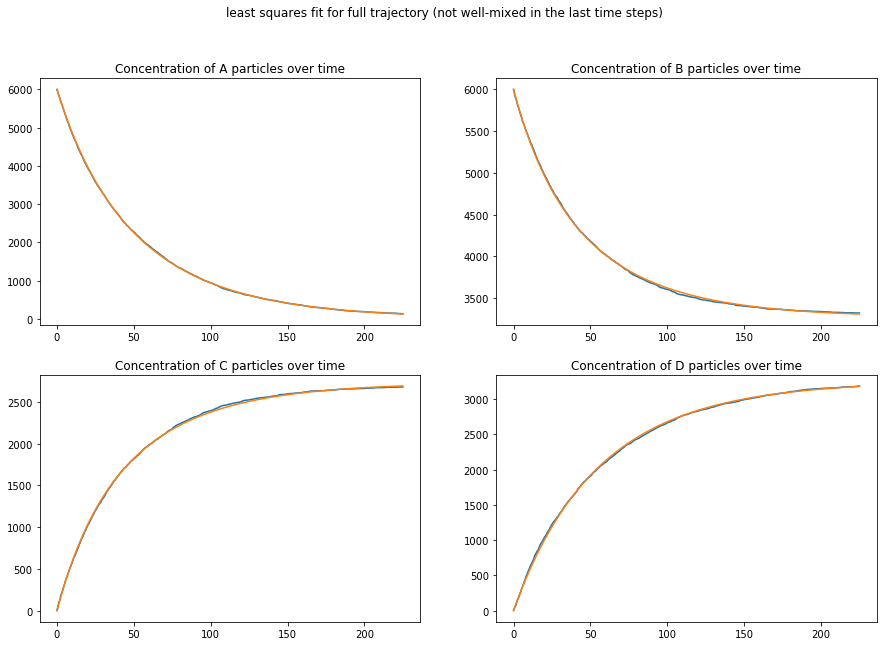

In [26]:
def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(estimator.coefficients_, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()

# grid search

In [2]:
traj = pat.Trajectory("../generate/simple_trajectory_.h5")
traj.counts = traj.counts[:45*500]
traj.update()
bfc = BasisFunctionConfiguration(traj)
bfc.add_fusion(0, 1, 2)
bfc.add_fission(2, 0, 1)
bfc.add_conversion(0, 1)
bfc.add_conversion(0, 3)ReaDDyElasticNetEstimator
bfc.add_conversion(3, 0)
estimator = ReaDDyElasticNetEstimator(traj.counts, traj.dcounts_dt, bfc, 1. / (2. * traj.n_species * traj.n_time_steps))

max counts = 6000.0, min nonzero counts = 1.0


In [6]:
parameter_grid = {'alpha': np.arange(100, 300, 10), 'l1_ratio': np.arange(0, 1, .1)}
cv = TimeSeriesSplit(3)
gs = GridSearchCV(estimator, parameter_grid, n_jobs=8, cv=cv)

In [7]:
gs.fit(range(0, traj.n_time_steps), y=traj.dcounts_dt)

GridSearchCV(cv=TimeSeriesSplit(n_splits=3), error_score='raise',
       estimator=ReaDDyElasticNetEstimator(alpha=1.0,
             basis_function_configuration=<py_analyze_tools.sklearn.BasisFunctionConfiguration object at 0x7f22874c5630>,
             counts=array([[  6.00000e+03,   6.00000e+03,   0.00000e+00,   0.00000e+00],
       [  5.99600e+03,   5.99700e+03,   3.... 0.],
       [   0.,    0.,    0.,    0.]]),
             l1_ratio=1.0, scale=5.555555555555556e-06),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'alpha': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290]), 'l1_ratio': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [9]:
best_est = gs.best_estimator_

In [10]:
best_est.alpha

160

In [11]:
best_est.l1_ratio

0.0

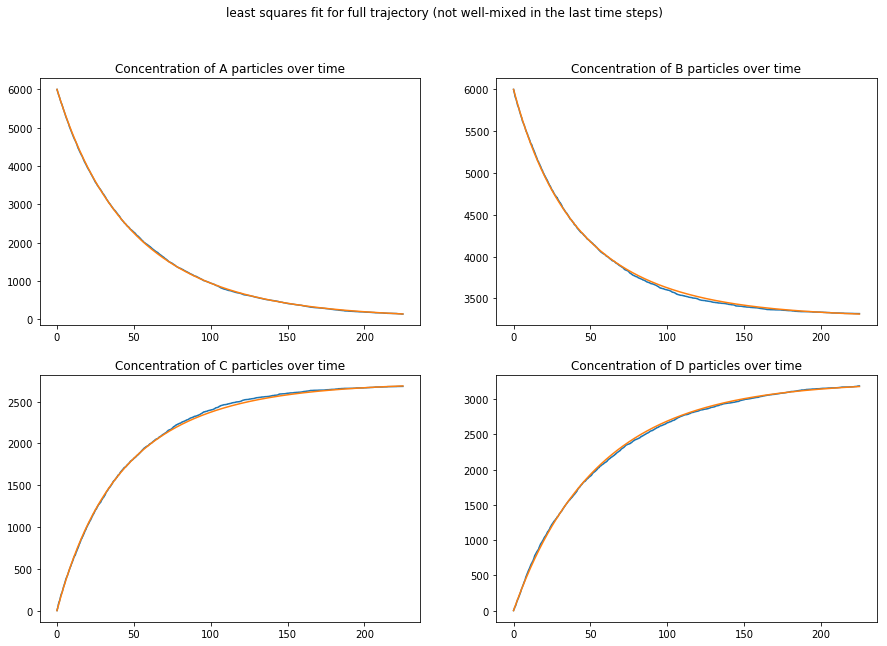

In [12]:
def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(best_est.coefficients_, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.show()

In [13]:
best_est.coefficients_

array([  1.92418072e-06,   6.39676843e-05,   0.00000000e+00,
         1.02754436e-02,   6.63671794e-05])

In [20]:
import functools
import operator
def rate_info(xi, diffusion_coefficient=.2, microscopic_rate=.05, reaction_radius=.7):
        tmp = np.sqrt(microscopic_rate / diffusion_coefficient) * reaction_radius
        rate_chapman = 4. * np.pi * diffusion_coefficient * reaction_radius * (1. - np.tanh(tmp) / tmp)
        rate_per_volume = xi * functools.reduce(operator.mul, [15,15,15], 1)

        print("erban chapman rate (per volume): {}".format(rate_chapman))
        print("lasso fitted rate (per counts): {}".format(xi))
        print("lasso fitted rate (per volume): {}".format(rate_per_volume))

        return rate_chapman, xi, rate_per_volume

In [21]:
rate_info(best_est.coefficients_)

erban chapman rate (per volume): 0.06848398371542153
lasso fitted rate (per counts): [  1.92418072e-06   6.39676843e-05   0.00000000e+00   1.02754436e-02
   6.63671794e-05]
lasso fitted rate (per volume): [  6.49410992e-03   2.15890935e-01   0.00000000e+00   3.46796220e+01
   2.23989230e-01]


(0.068483983715421526,
 array([  1.92418072e-06,   6.39676843e-05,   0.00000000e+00,
          1.02754436e-02,   6.63671794e-05]),
 array([  6.49410992e-03,   2.15890935e-01,   0.00000000e+00,
          3.46796220e+01,   2.23989230e-01]))

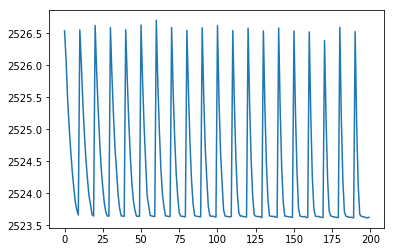

In [28]:
plt.plot(gs.cv_results_['mean_test_score'])

In [29]:
gs.best_params_

{'alpha': 160, 'l1_ratio': 0.0}